# Expression Data EDA

In [1]:
import requests
from IPython.core.display import HTML, display
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

%matplotlib inline

### Generate summaries of the expression data

In [22]:
# Import the TPM data
#tpm_data = pd.read_table("../Data/TPM_Combined/TPM_expression_counts_from_25_maize_lines_from_NAM_population.txt")

# Create a dataframe to exclusively hold the metadata
metadata = tpm_data[['Run', 'growth_condition', 'Cultivar', 
                     'Developmental_stage', 'organism_part', 'Age']]
# Create a dataframe that only holds the expression data
tpm_data = tpm_data.drop(['Run', 'growth_condition', 'Cultivar', 
                          'Developmental_stage', 'organism_part', 'Age'], axis=1)

In [29]:
# Generate descriptive summaries of the first few columns (excluding the genes)
metadata.head()

,Run,growth_condition,Cultivar,Developmental_stage,organism_part,Age
0,ERR3791403,field study,B97,FL.00 first flower(s) open stage,anther,77
1,ERR3791404,field study,B97,FL.00 first flower(s) open stage,anther,77
2,ERR3791405,field study,CML103,FL.00 first flower(s) open stage,anther,86
3,ERR3791406,field study,CML103,FL.00 first flower(s) open stage,anther,86
4,ERR3791407,green house study,CML277,FL.00 first flower(s) open stage,anther,105


In [25]:
# Determine the developmental stages and the parts
development_stages = np.unique(metadata['Developmental_stage'])
print(f"The different developmental stages are as follows (there are {len(development_stages)}):")
print(development_stages)
organism_parts = np.unique(metadata['organism_part'])
print(f"The different organism parts are as follows (there are {len(organism_parts)}):")
print(organism_parts)

The different developmental stages are as follows (there are 5):
['FL.00 first flower(s) open stage' 'LP.11 eleven leaves visible stage'
 'LP.18 eighteen leaves visible stage' 'adult' 'seedling']
The different organism parts are as follows (there are 11):
['anther' 'ear inflorescence' 'endosperm' 'leaf' 'leaf base' 'leaf tip'
 'plant embryo' 'root' 'shoot' 'shoot system' 'tassel inflorescence']


### Remove lowly expressed genes and log transform the data
It is common to both remove lowly expressed genes (e.g. genes that are not expressed in over 80% of the samples) and log transform the data (with a small offset before applying the log transformation).

In [34]:
# Determine lowly expressed genes (not expressed in over 80% of samples and max expression level is less than 1)
lowly_expressed = []
cutoff = 0.8*tpm_data.shape[0]
for gene in tpm_data.columns:
    data = tpm_data[gene]
    # Determine the number of samples that do not express the given gene
    num_no_expression = np.sum(data == 0)
    lowly_expressed.append((num_no_expression >= cutoff) & (np.max(data) < 2))

# Compute the number of lowly expressed genes
num_lowly_expressed = np.sum(lowly_expressed)
print(f"There are {num_lowly_expressed} lowly expressed genes.")

There are 7733 lowly expressed genes.


In [40]:
# Remove lowly expressed genes
tpm = tpm_data.loc[:,~np.array(lowly_expressed)]
# Log transform the tpm data
log_tpm = np.log2(tpm + 1)

### Gene Expression Distributions
Plot the distribution of the average expression per gene (across all samples and for each individual)

In [50]:
# Calculate the mean expression level for every gene
mean_expression = log_tpm.mean(axis=0)
len(mean_expression)
# Calculated the mean expression level for every gene per individual
log_tpm['Cultivar'] = metadata['Cultivar']
mean_exp_individual = log_tpm.groupby(by=['Cultivar']).mean()


In [54]:
mean_exp_individual.index

Index(['B97', 'CML103', 'CML228', 'CML247', 'CML277', 'CML322', 'CML333',
       'CML52', 'CML69', 'HP301', 'IL14H', 'Ki11', 'Ki3', 'Ky21', 'M162W',
       'M37W', 'MS71', 'Mo18W', 'NC350', 'NC358', 'Oh43', 'Oh7B', 'P39',
       'Tx303', 'Tzi8'],
      dtype='object', name='Cultivar')

Text(0.5, 1.0, 'Average Expression')

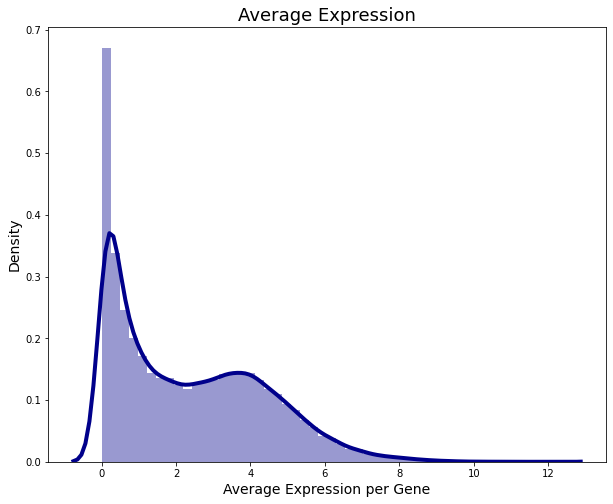

In [55]:
# Plot the distribution for the mean expression level across all samples across genes
fig, ax = plt.subplots(figsize=(10,8))
sns.distplot(mean_expression, kde=True, color = 'darkblue', 
             kde_kws={'linewidth': 4}, ax = ax)
ax.set_xlabel('Average Expression per Gene', size = 14)
ax.set_ylabel('Density', size = 14)
ax.set_title('Average Expression', size = 18)

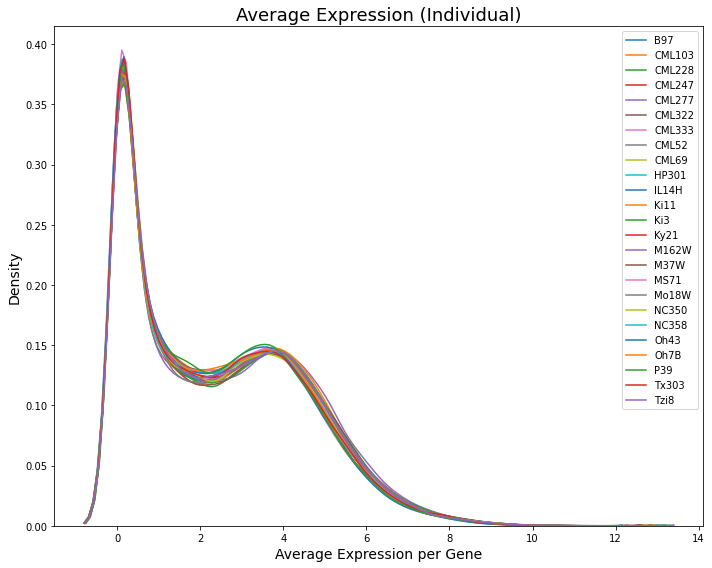

In [59]:
# Plot the distribution for the mean expression level per individual across genes
fig, ax = plt.subplots(figsize=(10,8))
for individual in mean_exp_individual.index:
    sns.kdeplot(mean_exp_individual.loc[individual], label = individual, ax = ax)
ax.set_xlabel('Average Expression per Gene', size = 14)
ax.set_ylabel('Density', size = 14)
ax.set_title('Average Expression (Individual)', size = 18)
plt.tight_layout();

### Perform dimensionality reduction on the data
We would like to determine whether individuals or tissues cluster together (among other characteristics such as age).

In [60]:
import scprep
from sklearn.manifold import TSNE

In [ ]:
# Drop the Cultivar column
log_tpm = log_tpm.drop(['Cultivar'], axis=1)

In [64]:
# Perform PCA on the data
pca, singular_values = scprep.reduce.pca(log_tpm, n_components = 50, return_singular_values = True)
percent_variance = (singular_values**2/sum(singular_values**2))*100  # Calculate percent variance explained

# Perform TSNE on the data
tsne_operator = TSNE(n_components = 2, perplexity = 30, random_state = 10)  # Perplexity usually set 5-50 (loosely number of neighbors)
tsne = pd.DataFrame(tsne_operator.fit_transform(pca.iloc[:,0:50]))  # Perform tSNE on first 50 PC's

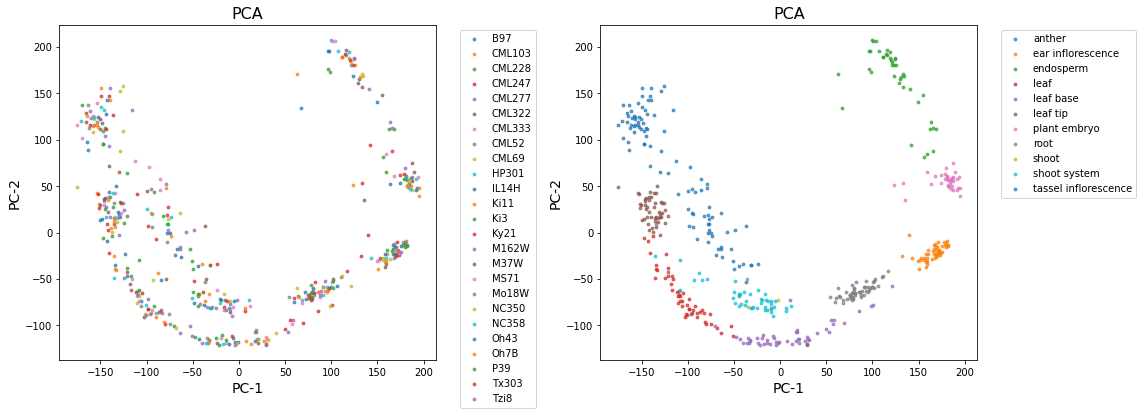

In [95]:
# Create PCA plots colored by individual and tissue
fig, axes = plt.subplots(1,2,figsize = (16, 6))
ax = axes.flatten()
for individual in np.unique(metadata['Cultivar']):
    indices_to_keep = np.where(metadata['Cultivar'] == individual)[0]
    ax[0].scatter(x = pca.iloc[indices_to_keep,0], y = pca.iloc[indices_to_keep,1], 
                    s = 8, alpha = 0.7, label = individual)
    ax[0].set_xlabel("PC-1", fontsize = 14)
    ax[0].set_ylabel("PC-2", fontsize = 14)
    ax[0].set_title("PCA", fontsize = 16)
for tissue in np.unique(metadata['organism_part']):
    indices_to_keep = np.where(metadata['organism_part'] == tissue)[0]
    ax[1].scatter(x = pca.iloc[indices_to_keep,0], y = pca.iloc[indices_to_keep,1], 
                    s = 8, alpha = 0.7, label = tissue)
    ax[1].set_xlabel("PC-1", fontsize = 14)
    ax[1].set_ylabel("PC-2", fontsize = 14)
    ax[1].set_title("PCA", fontsize = 16)
ax[0].legend(bbox_to_anchor=(1.05, 1))
ax[1].legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout();

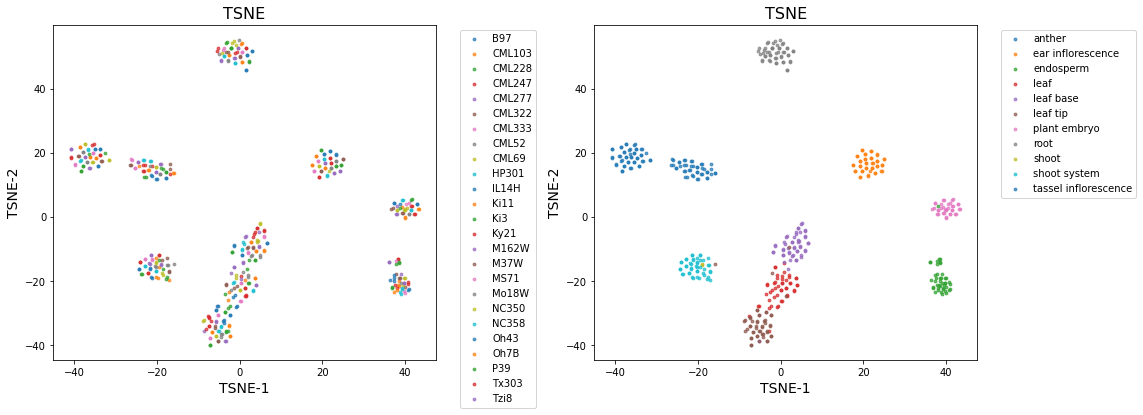

In [97]:
# Create TSNE plots colored by individual and tissue
fig, axes = plt.subplots(1,2,figsize = (16, 6))
ax = axes.flatten()
for individual in np.unique(metadata['Cultivar']):
    indices_to_keep = np.where(metadata['Cultivar'] == individual)[0]
    ax[0].scatter(x = tsne.iloc[indices_to_keep,0], y = tsne.iloc[indices_to_keep,1], 
                    s = 8, alpha = 0.7, label = individual)
    ax[0].set_xlabel("TSNE-1", fontsize = 14)
    ax[0].set_ylabel("TSNE-2", fontsize = 14)
    ax[0].set_title("TSNE", fontsize = 16)
for tissue in np.unique(metadata['organism_part']):
    indices_to_keep = np.where(metadata['organism_part'] == tissue)[0]
    ax[1].scatter(x = tsne.iloc[indices_to_keep,0], y = tsne.iloc[indices_to_keep,1], 
                    s = 8, alpha = 0.7, label = tissue)
    ax[1].set_xlabel("TSNE-1", fontsize = 14)
    ax[1].set_ylabel("TSNE-2", fontsize = 14)
    ax[1].set_title("TSNE", fontsize = 16)
ax[0].legend(bbox_to_anchor=(1.05, 1))
ax[1].legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout();

We can see from the above PCA and TSNE plots that there is a clear separation by tissue. Tissue type is the major signal driving the variability in our data.